#Library

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0
from torchvision.models import EfficientNet_B0_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(42)
torch.manual_seed(42)

#Data Splitting

In [4]:
train_directory="/kaggle/input/experimental-dataset/New Dataset CCTV Persimpangan Kota Bandung/Training Dataset"
val_directory="/kaggle/input/experimental-dataset/New Dataset CCTV Persimpangan Kota Bandung/Validation Dataset"
test_directory="/kaggle/input/experimental-dataset/New Dataset CCTV Persimpangan Kota Bandung/Testing Dataset"

classes=['Empty', 'High', 'Low', 'Medium', 'Traffic Jam']

batch_size=8
device="cuda"

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

#EDA

In [ ]:
directories=[train_directory,val_directory,test_directory]
img_shapes=[]

for i,directory in enumerate(directories):
    for density_dir_name in os.listdir(directory):
        density_dir_path=os.path.join(directory,density_dir_name)
        for img_file_name in os.listdir(density_dir_path):
            img_path=os.path.join(density_dir_path,img_file_name)
            img=cv2.imread(img_path)
            img_shapes.append([img.shape[0],img.shape[1],directory.split("/")[-1]])

img_shape_data=pd.DataFrame(data=img_shapes,columns=["height","width","split"])

In [ ]:
img_shape_data.groupby("split")[["height","width"]].describe().T

In [ ]:
sns.histplot(img_shape_data["height"],kde=True);

In [ ]:
sns.histplot(img_shape_data["width"],kde=True);

In [ ]:
directories=[train_directory,val_directory,test_directory]
total_instances=[3378,340,320]
instances_list=[]
for i,directory in enumerate(directories):
    for density_dir_name in os.listdir(directory):
        density_dir_path=os.path.join(directory,density_dir_name)
        instances=round(len(os.listdir(density_dir_path))/total_instances[i],2)
        instances_list.append([directory.split("/")[-1].capitalize(),density_dir_name,
                               instances])

inter=pd.DataFrame(data=instances_list,columns=["Dataset_split","Density_type","Percentage"])
sns.barplot(data=inter,x="Dataset_split",y="Percentage",hue="Density_type");

#Image Augmentation

In [ ]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=5,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=400,width=600),
                           A.Normalize(),
                           ToTensorV2()])

val_transform=A.Compose([A.Resize(height=400,width=600),
                         A.Normalize(),
                         ToTensorV2()])

In [ ]:
def open_img(img_path):
    img=Image.open(img_path)
    img=np.array(img)
    if img.shape[2]==3:
        return img
    else:
        return img[:,:,:-1]

class Transform():
    def __init__(self,transform):
        self.transform=transform
    def __call__(self,image):
        return self.transform(image=image)["image"]

#Dataset

In [ ]:
train_dataset=ImageFolder(train_directory,transform=Transform(train_transform),loader=open_img)
val_dataset=ImageFolder(val_directory,transform=Transform(val_transform),loader=open_img)
test_dataset=ImageFolder(test_directory,transform=Transform(val_transform),loader=open_img)

In [ ]:
train_dl=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    pin_memory=True if device is "cuda" else False)
val_dl=DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  pin_memory=True if device is "cuda" else False)
test_dl=DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                   pin_memory=True if device is "cuda" else False)

#Visualisasi Dataset

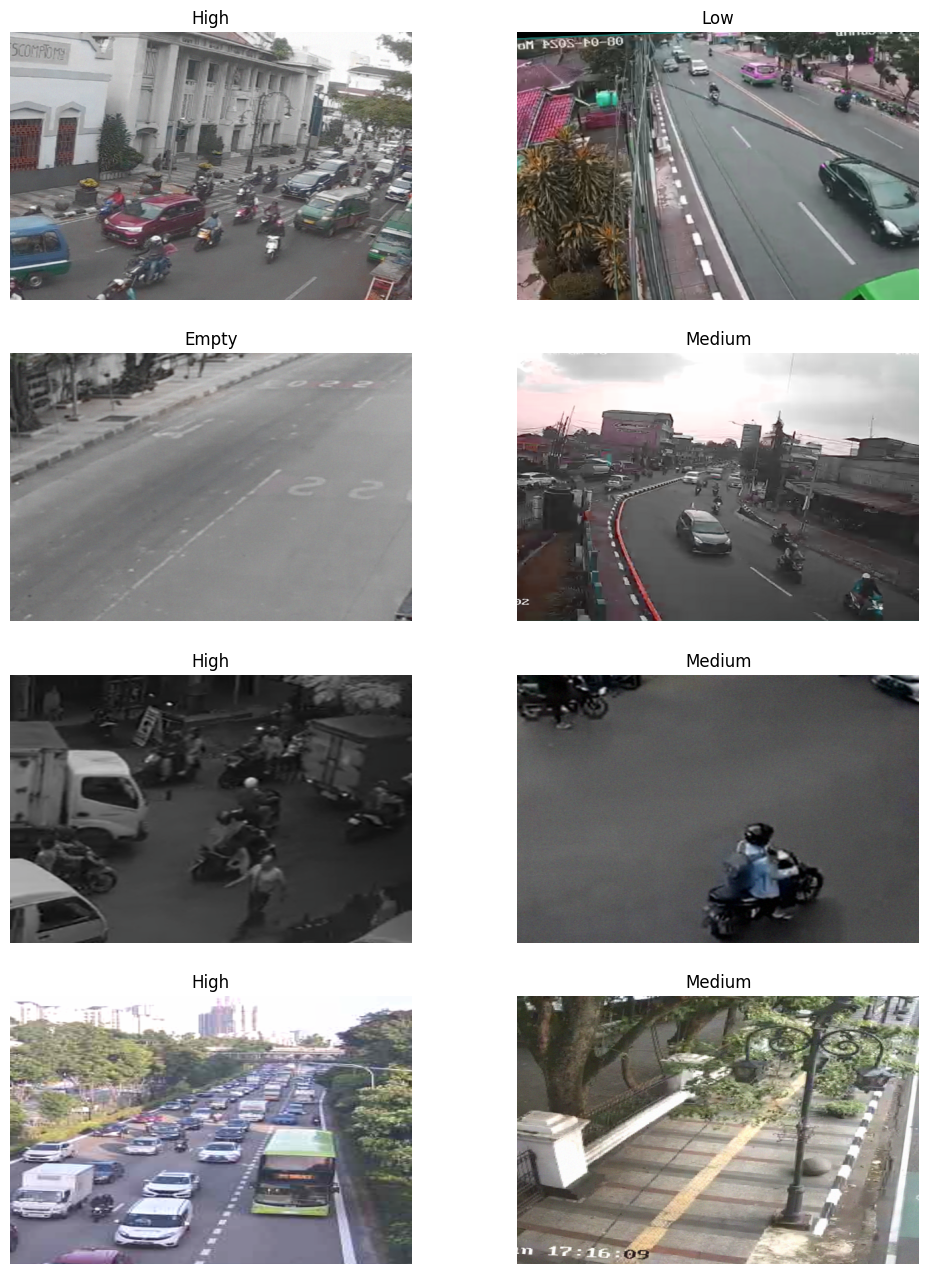

In [14]:
fig,axes=plt.subplots(4,2,figsize=(12,16))
ax=axes.flatten()
imgs,labels=next(iter(train_dl))


for i,img in enumerate(imgs):
    imgp=np.transpose(img.numpy().copy(),(1,2,0))*std+mean
    ax[i].imshow(imgp)
    ax[i].set_title(classes[labels[i].item()])
    ax[i].axis("off")

#Train

In [15]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

def training(model,epochs,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,weights_path):
    best_val_acc=0.0
    patience=10
    best_weights=copy.deepcopy(model.state_dict())
    loss_dict={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

    for epoch in range(epochs):

        train_loss=0.0
        train_acc=0.0
        train_len=len(train_dl.dataset)
        val_loss=0.0
        val_acc=0.0
        val_len=len(val_dl.dataset)
        current_lr=get_lr(optimizer)

        model.train()
        for imgs,labels in train_dl:
            imgs,labels=imgs.to(device),labels.to(device)
            output=model(imgs)
            loss=loss_fn(output,labels)

            train_loss+=loss.item()
            pred_labels=output.argmax(dim=1)
            train_acc+=(labels==pred_labels).sum().item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            for imgs,labels in val_dl:
                imgs,labels=imgs.to(device),labels.to(device)
                output=model(imgs)
                loss=loss_fn(output,labels)

                val_loss+=loss.item()
                pred_labels=output.argmax(dim=1)
                val_acc+=(labels==pred_labels).sum().item()

        lr_scheduler.step(val_loss)
        if current_lr!=get_lr(optimizer):
            print("Loading best Model weights")
            model.load_state_dict(best_weights)

        if val_acc>best_val_acc:
            best_val_acc=val_acc
            best_weights=copy.deepcopy(model.state_dict())
            print("Updating Best Model weights")

        loss_dict["train_loss"].append(train_loss/train_len)
        loss_dict["train_acc"].append(train_acc/train_len)
        loss_dict["val_loss"].append(val_loss/val_len)
        loss_dict["val_acc"].append(val_acc/val_len)

        print(f"{epoch+1}/{epochs}: Training\nloss: {train_loss/train_len} accuracy: {train_acc/train_len}")
        print(f"{epoch+1}/{epochs}: Evaluating\nloss: {val_loss/val_len} accuracy: {val_acc/val_len}")
        print("*"*50,"\n")

    torch.save(best_weights,weights_path)
    return loss_dict

In [16]:
def get_model(weights=None):
    model=efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    in_features=model.classifier[1].in_features
    model.classifier[1]=nn.Linear(in_features=in_features,out_features=5)
    model.to(device)

    return model

#Transfer learning from EfficientNet

In [17]:
weights=EfficientNet_B0_Weights.DEFAULT
model=get_model(weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 111MB/s] 


#Without Fine Tuning


In [18]:
import shutil
src_path = '/kaggle/input/pretrainedmodel/efficientnet_b0_rwightman-7f5810bc.pth'
dst_path = '/kaggle/working/efficientnet_b0_rwightman-7f5810bc.pth'

shutil.copy(src_path, dst_path)

print("File copied to:", dst_path)


File copied to: /kaggle/working/efficientnet_b0_rwightman-7f5810bc.pth


In [20]:
for name,params in model.named_children():
    if name!="classifier":
        params.requires_grad=False

optimizer=optim.Adam(model.classifier.parameters(),lr=1e-3)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
extractor_weights_path="/kaggle/working/efficientnet_b0_rwightman-7f5810bc.pth"

In [21]:
loss_dict=training(model,25,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,
                   extractor_weights_path)

Updating Best Model weights
1/25: Training
loss: 1.4513325627644857 accuracy: 0.397037037037037
1/25: Evaluating
loss: 1.4174841664320121 accuracy: 0.38650306748466257
************************************************** 

Updating Best Model weights
2/25: Training
loss: 1.311832701365153 accuracy: 0.4622222222222222
2/25: Evaluating
loss: 1.2928504475786642 accuracy: 0.4049079754601227
************************************************** 

Updating Best Model weights
3/25: Training
loss: 1.2087094179789226 accuracy: 0.5185185185185185
3/25: Evaluating
loss: 1.2066595481217273 accuracy: 0.4539877300613497
************************************************** 

Updating Best Model weights
4/25: Training
loss: 1.188093386049624 accuracy: 0.5096296296296297
4/25: Evaluating
loss: 1.1964580939591296 accuracy: 0.4601226993865031
************************************************** 

Updating Best Model weights
5/25: Training
loss: 1.172279298570421 accuracy: 0.49777777777777776
5/25: Evaluating
loss

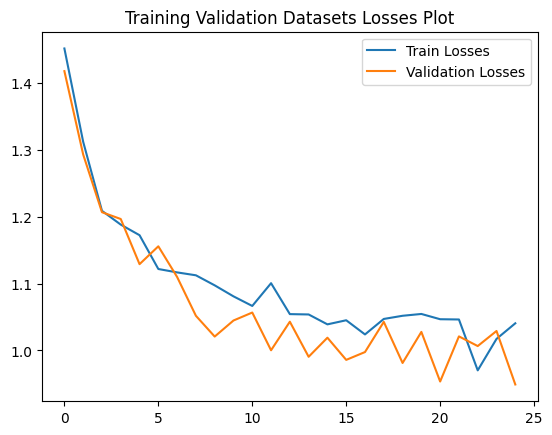

In [22]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

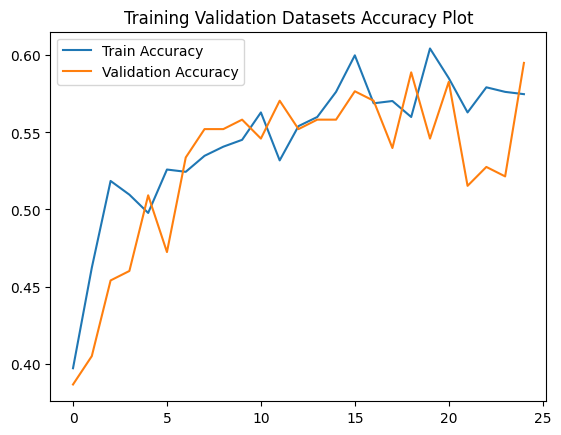

In [23]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

#Transfer Learning with Fine Tuning

In [24]:
model=get_model()
model.load_state_dict(torch.load("/kaggle/working/efficientnet_b0_rwightman-7f5810bc.pth"))

<All keys matched successfully>

In [25]:
src_path = '/kaggle/input/experimental-dataset/New Dataset CCTV Persimpangan Kota Bandung/Pre-trained Model/finetuning_model.pth'
dst_path = '/kaggle/working/finetuning_model.pth'

shutil.copy(src_path, dst_path)

print("File copied to:", dst_path)

File copied to: /kaggle/working/finetuning_model.pth


In [26]:
optimizer=optim.Adam(model.parameters(),lr=3e-5,weight_decay=1e-4)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)
loss_fn=nn.CrossEntropyLoss(reduction="sum")
finetuning_weights_path="/kaggle/working/finetuning_model.pth"

In [27]:
loss_dict=training(model,70,train_dl,val_dl,optimizer,lr_scheduler,loss_fn,
                   finetuning_weights_path)

Updating Best Model weights
1/70: Training
loss: 0.9581014315287272 accuracy: 0.6177777777777778
1/70: Evaluating
loss: 0.9396209219482048 accuracy: 0.5644171779141104
************************************************** 

Updating Best Model weights
2/70: Training
loss: 0.9685607606393319 accuracy: 0.5911111111111111
2/70: Evaluating
loss: 0.9103912722113674 accuracy: 0.5828220858895705
************************************************** 

Updating Best Model weights
3/70: Training
loss: 0.9036448680029975 accuracy: 0.6177777777777778
3/70: Evaluating
loss: 0.8765587748194034 accuracy: 0.6257668711656442
************************************************** 

4/70: Training
loss: 0.8761960273318821 accuracy: 0.6370370370370371
4/70: Evaluating
loss: 0.859260049334333 accuracy: 0.6012269938650306
************************************************** 

5/70: Training
loss: 0.9227562120225694 accuracy: 0.6237037037037036
5/70: Evaluating
loss: 0.883897057340189 accuracy: 0.6012269938650306
******

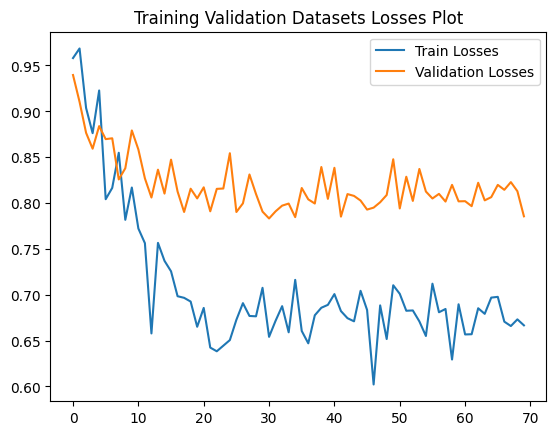

In [28]:
x=range(len(loss_dict['train_loss']))
sns.lineplot(x=x,y=loss_dict['train_loss'],label="Train Losses");
sns.lineplot(x=x,y=loss_dict['val_loss'],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();

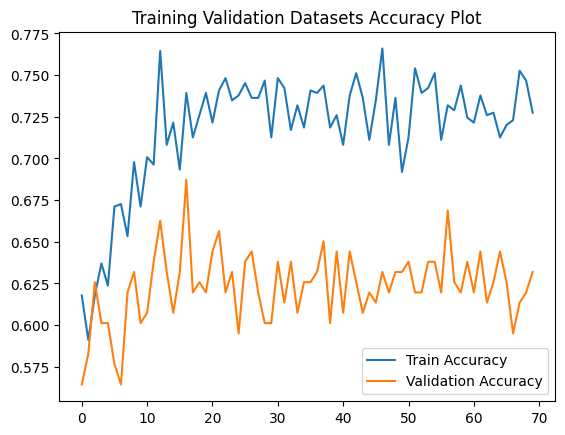

In [29]:
sns.lineplot(x=x,y=loss_dict['train_acc'],label="Train Accuracy");
sns.lineplot(x=x,y=loss_dict['val_acc'],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();

#Model Evaluation

In [30]:
model=get_model()
model.load_state_dict(torch.load("/kaggle/working/finetuning_model.pth"))

<All keys matched successfully>

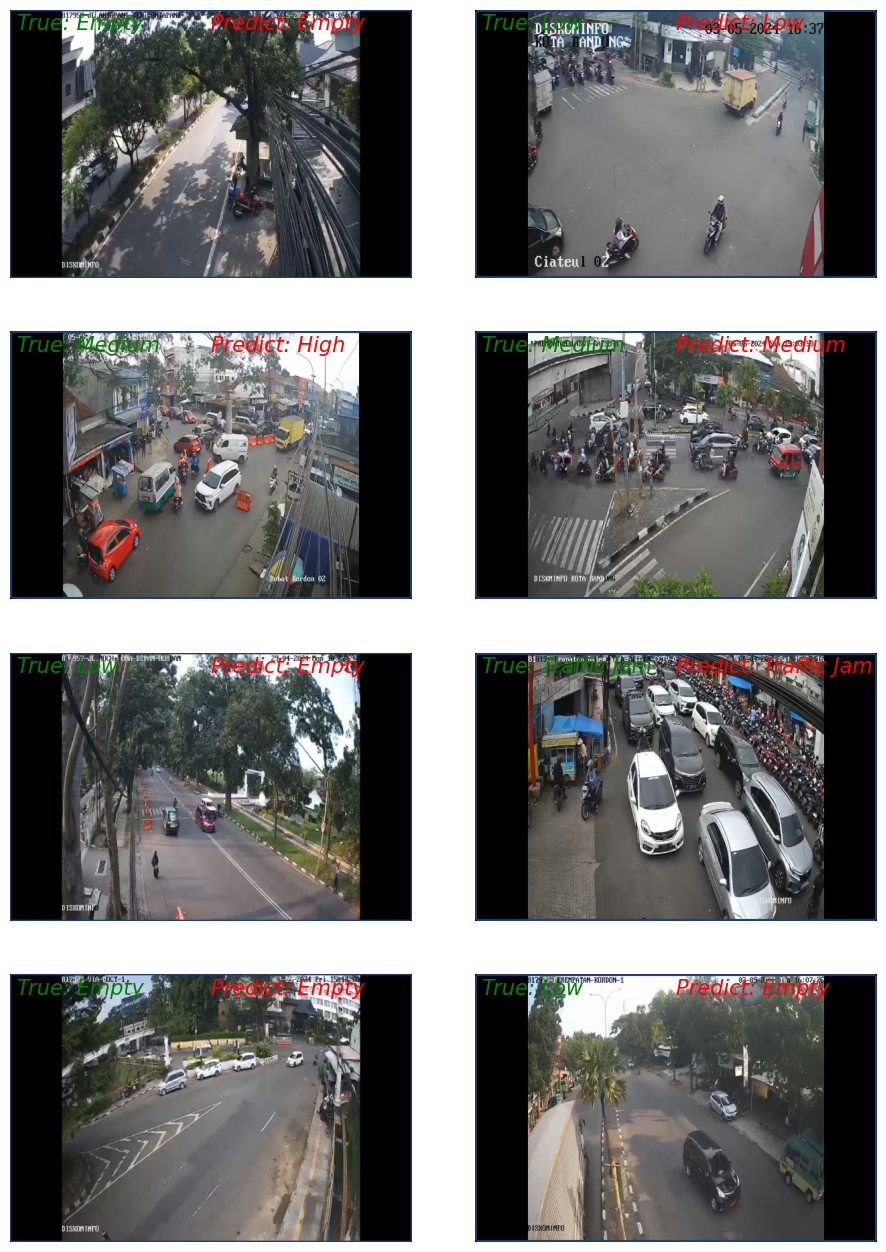

In [31]:
fig,axes=plt.subplots(4,2,figsize=(12,16))
plt.subplots_adjust(wspace=0)
ax=axes.flatten()

imgs,labels=next(iter(test_dl))
model.eval()
with torch.no_grad():
    imgs=imgs.to(device)
    output=model(imgs)

for i in range(imgs.shape[0]):
    pred_label=output[i].argmax(0)
    ax[i].imshow(imgs[i].permute(1,2,0).cpu().numpy()*std+mean)
    ax[i].text(10,30,"True: "+ classes[labels[i].item()],style ='italic',
               fontsize = 15, color ="green")
    ax[i].text(300,30,"Predict: "+ classes[pred_label.item()],style ='italic',
                fontsize = 15, color ="red")
    ax[i].axis("off")

plt.savefig("6.png");

In [36]:
#save model
torch.save(model.state_dict(), "ModelParameter.pth")